In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline
import matplotlib.font_manager as fm
chinesefont = fm.FontProperties(fname='/Users/liujiangping/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/simhei.ttf')

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#sbn.set_style('ticks') # 设置图表风格
#sbn.set(font_scale=1.7) # 设置图表字体大小
font = {'color'  : 'darkred',  
        'weight' : 'normal',  
        'size'   : 16  
        }  
## 目的：预测泰坦尼克号船员生还概率

# 第一步: 读取训练数据
train_data = pd.read_csv('train.csv')

In [4]:
# 第二步: 观察数据
# 列名解释:
# PassengerId: 乘客ID,不做为特征
# Survived: 生还状态,label值,0=未生还 1=生还
# Pclass: 船票等级,特征值,数字,类目型,1=高级,2=中级,3=低级
# Name: 乘客姓名,特征值,文本
# Sex: 乘客性别,特征值,文本,类目型,male=男,female=女
# Age: 乘客年龄,特征值,数字,连续型
# SibSp: 兄弟姐妹及配偶数量,特征值,数字,连续型
# Parch: 子女及父母数量,特征值,数字,连续型
# Ticket: 船票号码,特征值,文本
# Fare: 船票价格,特征值,数字
# Cabin: 船舱房间号码,特征值,文本
# Embarked: 登船口岸,特征值,文本,类目型,C,Q,S

# 1.查看数据基本信息
# 891个样本,12列,只有Age、Cabin、Embarked有缺失值,其中Cabin缺失值数量超过3/4
train_data.info()
# 2.查看各数值列的均值、最小值、最大值、分位数、标准偏差
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [82]:
def plot_feature_count_bar(feature, title, xlabel):
    feature_plot = train_data[feature].value_counts().plot(kind='bar')
    feature_plot.set_xticklabels(feature_plot.get_xticklabels(),rotation=0)
    feature_plot.set_title(title,fontproperties=chinesefont,fontdict=font,fontsize=40)
    feature_plot.set_xlabel(xlabel,fontproperties=chinesefont,fontdict=font,fontsize=40)
    feature_plot.set_ylabel(u'人数',fontproperties=chinesefont,fontdict=font,fontsize=40)


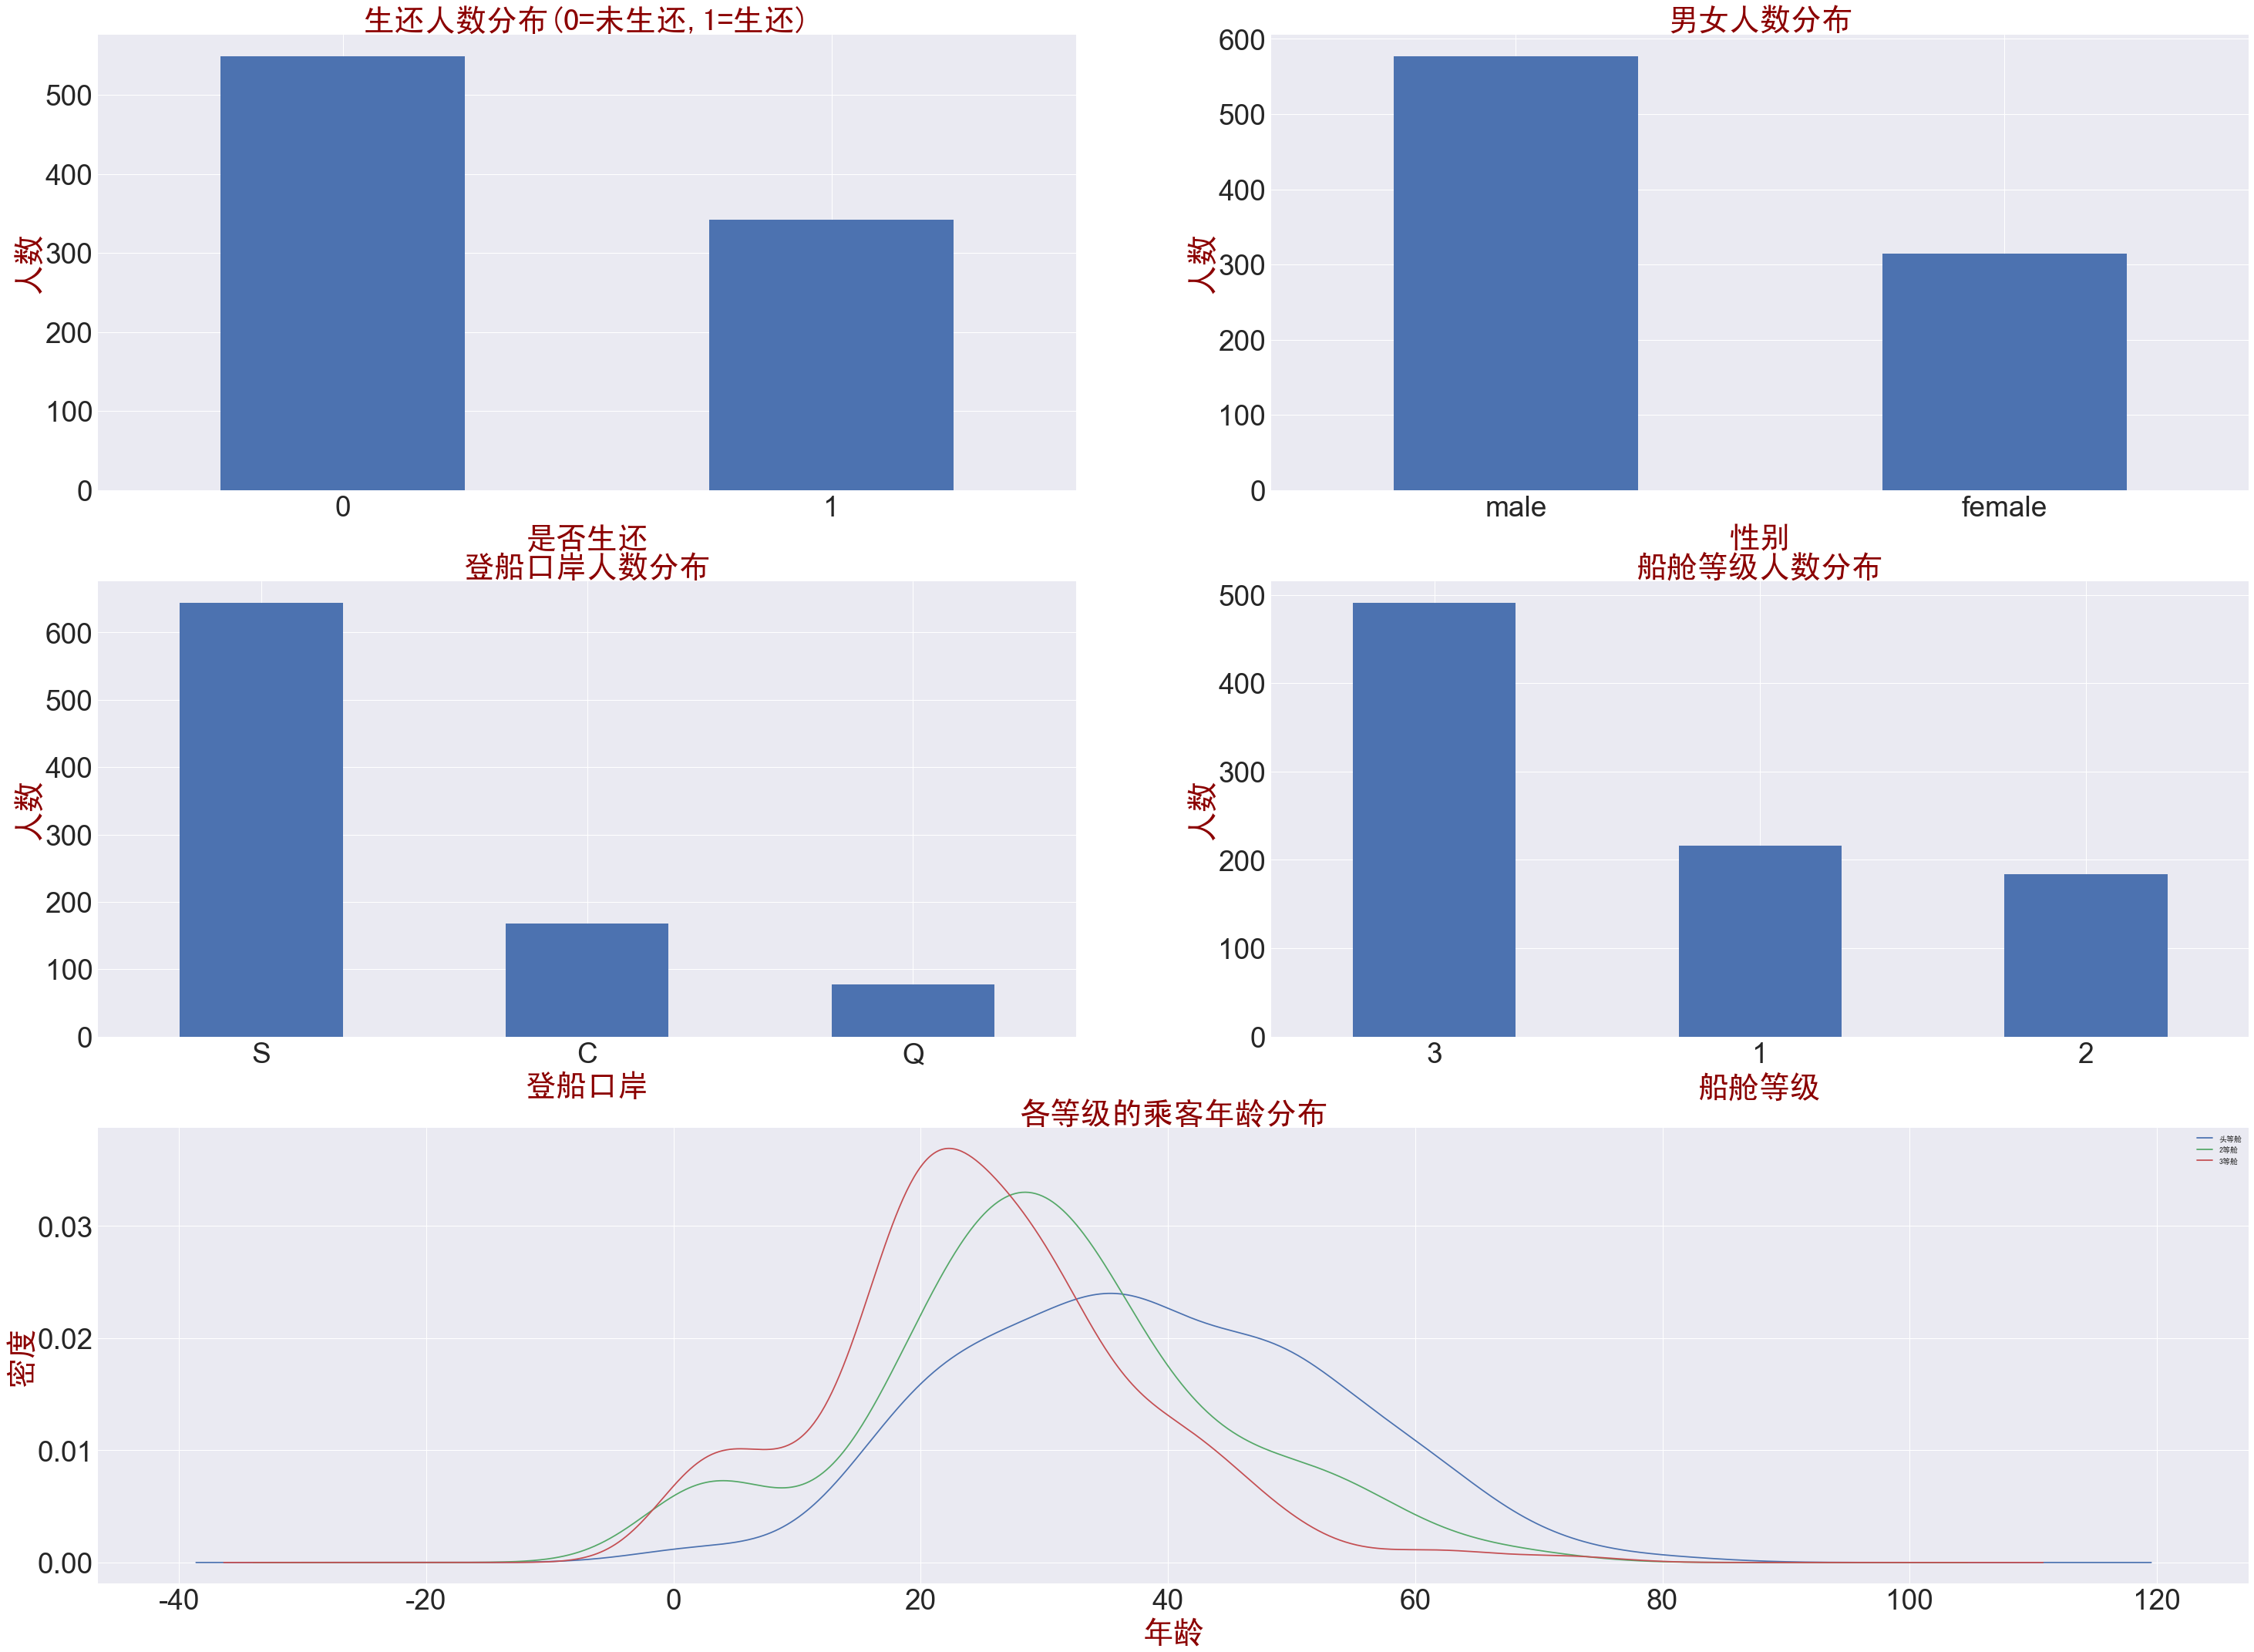

In [87]:
sbn.set(font_scale=3.7)
plt.figure(figsize=(50,50)) # 画布大小

plt.subplot2grid((4,2),(0,0))
plot_feature_count_bar('Survived', u'生还人数分布(0=未生还,1=生还)', '是否生还')

plt.subplot2grid((4,2),(0,1))
plot_feature_count_bar('Sex', u'男女人数分布', '性别')

plt.subplot2grid((4,2),(1,0))
plot_feature_count_bar('Embarked', u'登船口岸人数分布', '登船口岸')

plt.subplot2grid((4,2),(1,1))
plot_feature_count_bar('Pclass', u'船舱等级人数分布', '船舱等级')

plt.subplot2grid((4,2),(2,0), colspan=2)
train_data.Age[train_data.Pclass == 1].plot(kind='kde')
train_data.Age[train_data.Pclass == 2].plot(kind='kde')
train_data.Age[train_data.Pclass == 3].plot(kind='kde')
plt.xlabel(u'年龄',fontproperties=chinesefont,fontdict=font,fontsize=40)
plt.ylabel(u'密度',fontproperties=chinesefont,fontdict=font,fontsize=40)
plt.title(u'各等级的乘客年龄分布',fontproperties=chinesefont,fontdict=font,fontsize=40)
plt.legend((u'头等舱', u'2等舱', u'3等舱'),loc='best',prop=chinesefont)

plt.show()

In [101]:
# 画出各个特征的获救情况柱状图
def plot_feature_survived_bar(feature, title, xlabel):
    sbn.set(font_scale=1.7)
    plt.figure(figsize=(50,50))
    # 未获救
    Survived_0 = train_data[feature][train_data.Survived == 0].value_counts()
    # 获救
    Survived_1 = train_data[feature][train_data.Survived == 1].value_counts()
    Survived_df = pd.DataFrame({u'获救': Survived_1, u'未获救': Survived_0})
    Survived_df_plot = Survived_df.plot(kind='bar',stacked=True)
    plt.title(title,fontproperties=chinesefont,fontdict=font,fontsize=15)
    plt.xlabel(xlabel,fontproperties=chinesefont,fontdict=font,fontsize=15)
    plt.xticks(rotation=0)
    plt.ylabel(u'人数',fontproperties=chinesefont,fontdict=font,fontsize=15)
    Survived_labels = Survived_df_plot.get_legend_handles_labels()
    plt.legend(tuple(Survived_labels[1]),loc='best',prop=chinesefont)
    plt.show()


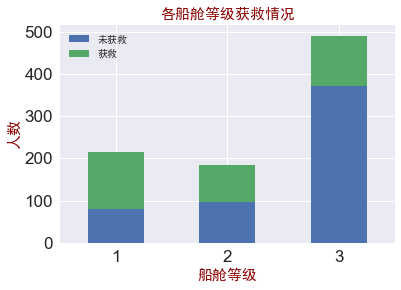

In [79]:
plot_feature_survived_bar('Pclass', '各船舱等级获救情况', '船舱等级')

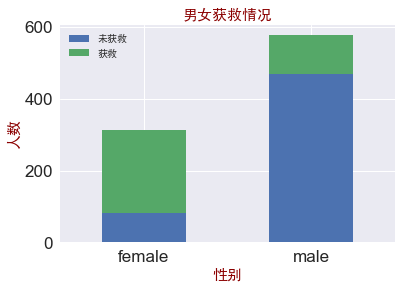

In [80]:
plot_feature_survived_bar('Sex', '男女获救情况', '性别')

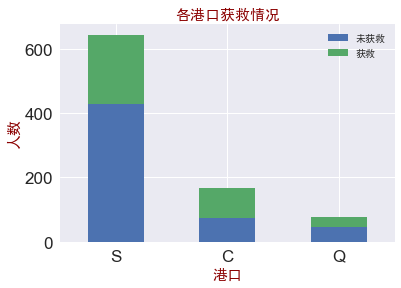

In [81]:
plot_feature_survived_bar('Embarked', '各港口获救情况', '港口')

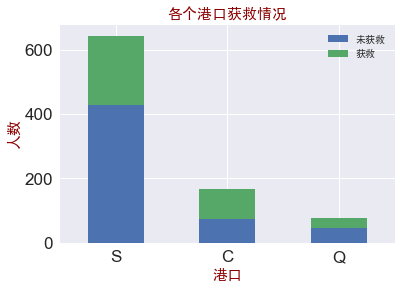

In [75]:
plot_feature_survived_bar('Embarked', '各港口获救情况', '港口')

In [96]:
def null2zero(x):
    if pd.isnull(x):
        return 0
    else:
        return 1

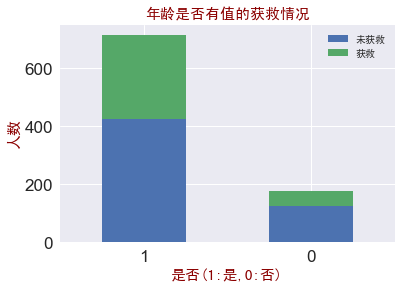

In [103]:
# 年龄是否有值的获救情况
train_data['Age_null'] = train_data['Age'].map(lambda x: null2zero(x))
plot_feature_survived_bar('Age_null', '年龄是否有值的获救情况', '是否(1:是,0:否)')

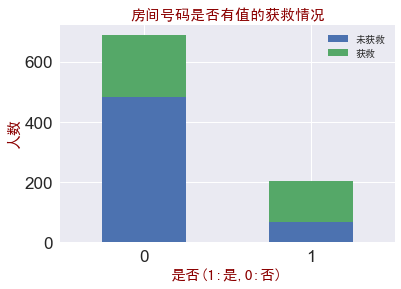

In [105]:
# 房间号码是否有值的获救情况
train_data['Cabin_null'] = train_data['Cabin'].map(lambda x: null2zero(x))
plot_feature_survived_bar('Cabin_null', '房间号码是否有值的获救情况', '是否(1:是,0:否)')

In [111]:
# 性别和船舱等级组合的获救情况
gb = train_data.groupby(['Sex','Pclass','Survived'])
print(gb.count()['PassengerId'])

Sex     Pclass  Survived
female  1       0             3
                1            91
        2       0             6
                1            70
        3       0            72
                1            72
male    1       0            77
                1            45
        2       0            91
                1            17
        3       0           300
                1            47
Name: PassengerId, dtype: int64


In [112]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_null,Cabin_null
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,1,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1,0


In [118]:
# 男1,女0
def sex2int(sex):
    if sex == 'male':
        return 1
    else:
        return 0

# S:1,C:2,Q:3
def embarked2int(embarked):
    if embarked == 'S':
        return 1
    elif embarked == 'C':
        return 2
    else:
        return 3

def age2int(age):
    if pd.isnull(age):
        return 0
    if age <= 18:
        return 1
    elif age > 18 and age <= 50:
        return 2
    else:
        return 3

In [122]:
def transform_feature_value():
    train_data['Sex_n'] = train_data['Sex'].map(lambda x: sex2int(x))
    train_data['Embarked_n'] = train_data['Embarked'].map(lambda x: embarked2int(x))
    train_data['Age_n'] = train_data['Age'].map(lambda x: age2int(x))


In [123]:
def standardization_value():
    

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_n,Embarked_n,Age_n
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,2,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,2
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,3,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,1,3
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1,1,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0,1,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0,2,1
